In [2]:
%load_ext autoreload
%autoreload 2
import os

from  partie1 import GRUEncoderGD, GRUDecoderGD
from  partie1 import GRUEncoderDG, GRUDecoderDG
from partie1 import TensorProductEncoder
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchmetrics.classification import Accuracy
import itertools
import pandas as pd


/home/baptiste/micromamba/envs/cours/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
input_size = 10
output_size = 10
batch_size = 16
seq_len = 10
epochs = 10000
learning_rate = 0.001
num_layers = 1

device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
precision= Accuracy(task="multiclass", num_classes=input_size).to(device) 

def generate_data(batch_size, seq_len, input_size):
    '''
    input_size : pour la plage de valeur 
    '''
    data = torch.randint(0, input_size, (batch_size, seq_len))  # fillers
    roles = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1)  # rôles
    return data, roles

# **Grid Search GRU**

## **Grid Search Gauche Droite**

In [ ]:


os.makedirs("./models/GD/", exist_ok=True)
os.makedirs("./resultats/GD/", exist_ok=True)


emb_sizes = [8, 16, 32, 64]  
hidden_sizes = [8, 16, 32, 64, 128] 

results = []
for emb_size, hidden_size in itertools.product(emb_sizes, hidden_sizes):
    print(f"\n--- emb_size={emb_size}, hidden_size={hidden_size} ---\n")
    
    # Définition du modèle
    # encoder = GRUEncoderGD(input_size, emb_size, hidden_size)
    # decoder = GRUDecoderGD(emb_size, hidden_size, output_size)
    encoder = GRUEncoderGD(input_size, emb_size, hidden_size, num_layers).to(device)
    decoder = GRUDecoderGD(emb_size, hidden_size, output_size, num_layers).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

    losses = []
    accuracies = []


    for epoch in range(epochs):
        data , _ = generate_data(batch_size, seq_len, input_size)
        data = data.to(device)
        

        _, hidden = encoder(data)
        hidden = hidden.to(device)
        # print(hidden.shape)
        hidden = hidden[-1].unsqueeze(0).repeat(num_layers, 1, 1) 
        # on fait ca pour ne garder que la sortie de la couche finale et la copier pour avoir le bon nombre de couches pour le décodeur
        # si on met une seule couche dans le décodeur ca bug et on veut pas la suite de couches différentes sinon on peut pas l'utiliser avec le tpdn

        # print(hidden.shape)
        reconstructed_x = decoder(hidden, seq_len) #.argmax(dim=1) pour la loss on prend les logits et pas les classes directement

        loss = criterion(reconstructed_x.view(-1, output_size), data.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracy = precision(reconstructed_x.argmax(dim=-1), data)
        losses.append(loss.item())
        accuracies.append(accuracy.cpu())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy*100:.2f}%")



    torch.save(encoder, f"./models/GD/gru_enc_emb{emb_size}_hid{hidden_size}.pth")
    torch.save(decoder, f"./models/GD/gru_dec_emb{emb_size}_hid{hidden_size}.pth")

    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.plot(range(epochs), losses, color='tab:blue', label='Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)', color='tab:orange')
    ax2.plot(range(epochs), accuracies, color='tab:orange', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    plt.title(f'Loss and Accuracy (emb={emb_size}, hid={hidden_size})')
    plt.savefig(f"./resultats/GD/training_gru_emb{emb_size}_hid{hidden_size}.png")
    plt.close()

    results.append({
        "emb_size": emb_size,
        "hidden_size": hidden_size,
        "final_loss": losses[-1],
        "final_accuracy": accuracies[-1].item()
    })

df_results = pd.DataFrame(results)
df_results.to_csv("./resultats/GD/grid_search_results.csv", index=False)

print("\n--- tableau svg ---")

In [5]:
df_results = pd.read_csv("./resultats/GD/grid_search_results.csv")
df_results

,emb_size,hidden_size,final_loss,final_accuracy
0,8,8,1.840307,0.3438
1,8,16,1.487727,0.3875
2,8,32,1.045227,0.6062
3,8,64,0.146321,0.9438
4,8,128,0.048828,0.9875
5,16,8,1.792798,0.3250
6,16,16,1.418317,0.4375
7,16,32,0.748182,0.7250
8,16,64,0.093686,0.9812
9,16,128,0.015651,0.9937


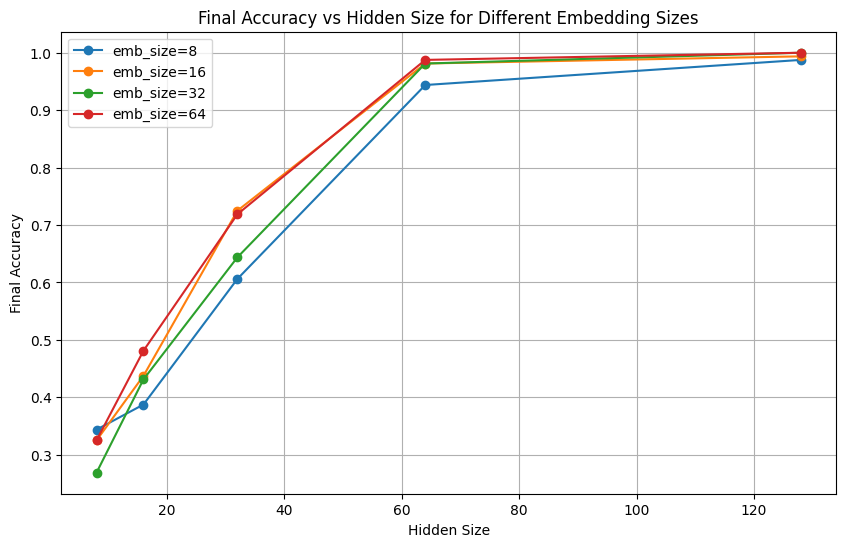

In [6]:
plt.figure(figsize=(10, 6))
for emb_size in df_results["emb_size"].unique():
    subset = df_results[df_results["emb_size"] == emb_size]
    plt.plot(subset["hidden_size"], subset["final_accuracy"], marker='o', label=f'emb_size={emb_size}')

plt.xlabel("Hidden Size")
plt.ylabel("Final Accuracy")
plt.title("Final Accuracy vs Hidden Size for Different Embedding Sizes")
plt.legend()
plt.grid()
plt.show()

On constate que emb_size=8 et hidden_size=64 fournissent un bon compromis performances/ temps d'exécution, on étudie maintenant l'influence du nombre de couches 


--- emb_size=8, hidden_size=64 ---

Epoch [10/10000], Loss: 2.3111, Accuracy: 9.38%
Epoch [20/10000], Loss: 2.3073, Accuracy: 6.88%
Epoch [30/10000], Loss: 2.3028, Accuracy: 8.75%
Epoch [40/10000], Loss: 2.3033, Accuracy: 12.50%
Epoch [50/10000], Loss: 2.2994, Accuracy: 11.25%
Epoch [60/10000], Loss: 2.3004, Accuracy: 15.62%
Epoch [70/10000], Loss: 2.3012, Accuracy: 8.75%
Epoch [80/10000], Loss: 2.2944, Accuracy: 14.38%
Epoch [90/10000], Loss: 2.2918, Accuracy: 10.62%
Epoch [100/10000], Loss: 2.2636, Accuracy: 13.12%
Epoch [110/10000], Loss: 2.2269, Accuracy: 18.12%
Epoch [120/10000], Loss: 2.1943, Accuracy: 15.62%
Epoch [130/10000], Loss: 2.2164, Accuracy: 18.75%
Epoch [140/10000], Loss: 2.2200, Accuracy: 16.88%
Epoch [150/10000], Loss: 2.1437, Accuracy: 18.75%
Epoch [160/10000], Loss: 2.1918, Accuracy: 16.25%
Epoch [170/10000], Loss: 2.1653, Accuracy: 20.00%
Epoch [180/10000], Loss: 2.1437, Accuracy: 15.00%
Epoch [190/10000], Loss: 2.0644, Accuracy: 25.00%
Epoch [200/10000], Loss: 2

,num_layers,final_loss,final_accuracy
0,1,0.291361,tensor(0.9000)
1,2,0.025950,tensor(0.9937)
2,5,0.000890,tensor(1.)
3,10,0.779443,tensor(0.6313)


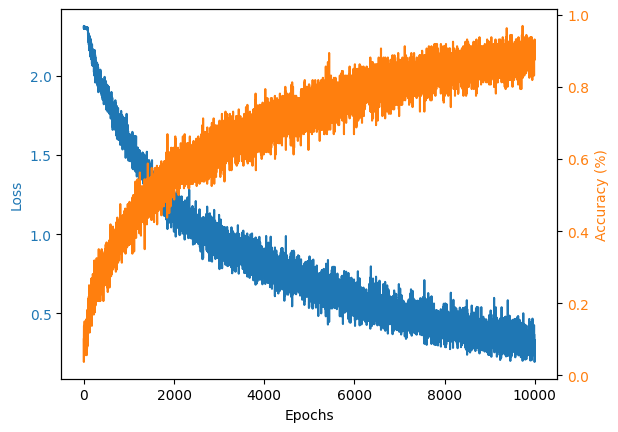

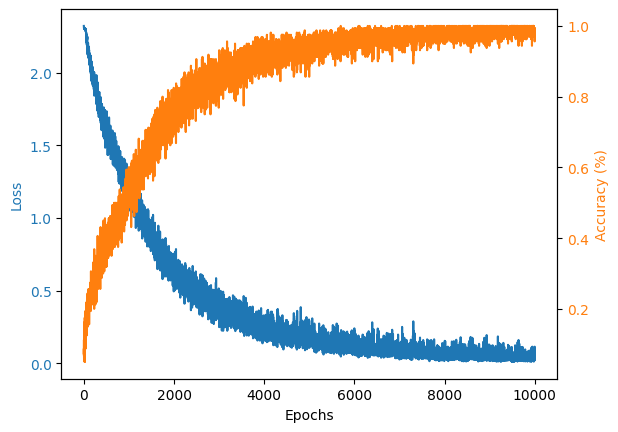

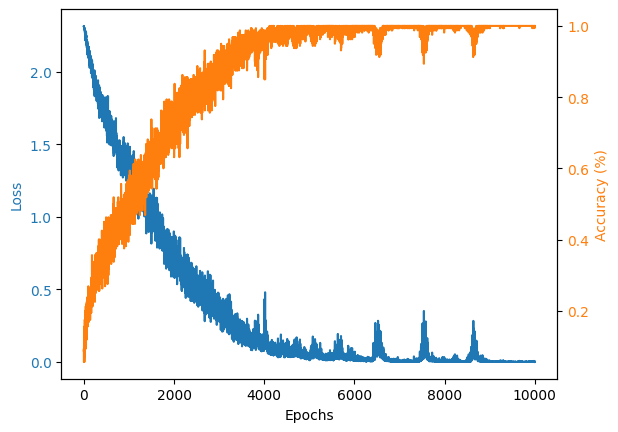

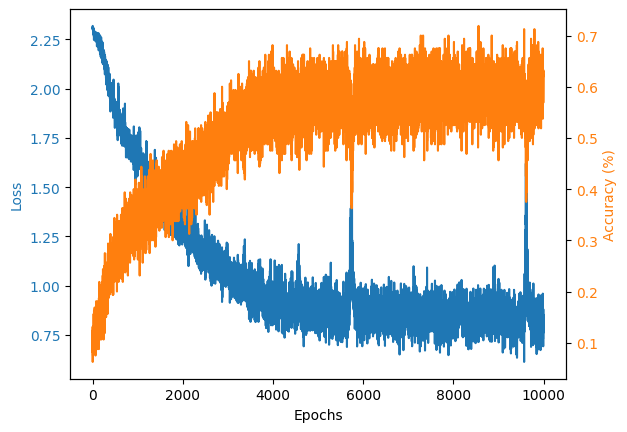

In [9]:


num_layers = [1, 2, 5, 10]  
emb_size=8
hidden_size = 64
results = []
for layer in num_layers:
    print(f"\n--- emb_size={emb_size}, hidden_size={hidden_size} ---\n")
    
    # Définition du modèle
    # encoder = GRUEncoderGD(input_size, emb_size, hidden_size)
    # decoder = GRUDecoderGD(emb_size, hidden_size, output_size)
    encoder = GRUEncoderGD(input_size, emb_size, hidden_size, num_layers=layer).to(device)
    decoder = GRUDecoderGD(emb_size, hidden_size, output_size, num_layers=layer).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

    losses = []
    accuracies = []


    for epoch in range(epochs):
        data , _ = generate_data(batch_size, seq_len, input_size)
        data = data.to(device)
        

        _, hidden = encoder(data)
        hidden = hidden.to(device)
        # print(hidden.shape)
        hidden = hidden[-1].unsqueeze(0).repeat(layer, 1, 1) 
        # on fait ca pour ne garder que la sortie de la couche finale et la copier pour avoir le bon nombre de couches pour le décodeur
        # si on met une seule couche dans le décodeur ca bug et on veut pas la suite de couches différentes sinon on peut pas l'utiliser avec le tpdn

        # print(hidden.shape)

        reconstructed_x = decoder(hidden, seq_len) #.argmax(dim=1) pour la loss on prend les logits et pas les classes directement

        loss = criterion(reconstructed_x.view(-1, output_size), data.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracy = precision(reconstructed_x.argmax(dim=-1), data)
        losses.append(loss.item())
        accuracies.append(accuracy.cpu())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy*100:.2f}%")



    # torch.save(encoder, f"./models/GD/gru_enc_emb{emb_size}_hid{hidden_size}.pth")
    # torch.save(decoder, f"./models/GD/gru_dec_emb{emb_size}_hid{hidden_size}.pth")

    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.plot(range(epochs), losses, color='tab:blue', label='Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)', color='tab:orange')
    ax2.plot(range(epochs), accuracies, color='tab:orange', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # plt.title(f'Loss and Accuracy (emb={emb_size}, hid={hidden_size})')
    # plt.savefig(f"./resultats/GD/training_gru_emb{emb_size}_hid{hidden_size}.png")
    # plt.close()

    results.append({
        "num_layers": layer,
        # "hidden_size": hidden_size,
        "final_loss": losses[-1],
        "final_accuracy": accuracies[-1]
    })

df_results = pd.DataFrame(results)
# df_results.to_csv("./resultats/GD/grid_search_results.csv", index=False)
df_results

On remarque que pour ces paramètres le modèles avec 5 couches performe bien mieux. 

## **Grid Search Droite Gauche**

In [8]:


os.makedirs("./models/DG/", exist_ok=True)
os.makedirs("./resultats/DG/", exist_ok=True)


emb_sizes = [8, 16, 32, 64]  
hidden_sizes = [8, 16, 32, 64, 128] 

results = []
for emb_size, hidden_size in itertools.product(emb_sizes, hidden_sizes):
    print(f"\n--- emb_size={emb_size}, hidden_size={hidden_size} ---\n")
    

    encoder = GRUEncoderDG(input_size, emb_size, hidden_size, num_layers).to(device)
    decoder = GRUDecoderDG(emb_size, hidden_size, output_size, num_layers).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

    losses = []
    accuracies = []


    for epoch in range(epochs):
        data , _ = generate_data(batch_size, seq_len, input_size)
        data = data.to(device)
        

        _, hidden = encoder(data)
        hidden = hidden.to(device)
        # print(hidden.shape)
        hidden = hidden[-1].unsqueeze(0).repeat(num_layers, 1, 1) 
        # on fait ca pour ne garder que la sortie de la couche finale et la copier pour avoir le bon nombre de couches pour le décodeur
        # si on met une seule couche dans le décodeur ca bug et on veut pas la suite de couches différentes sinon on peut pas l'utiliser avec le tpdn

        # print(hidden.shape)
        reconstructed_x = decoder(hidden, seq_len) #.argmax(dim=1) pour la loss on prend les logits et pas les classes directement

        loss = criterion(reconstructed_x.view(-1, output_size), data.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracy = precision(reconstructed_x.argmax(dim=-1), data)
        losses.append(loss.item())
        accuracies.append(accuracy.cpu())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy*100:.2f}%")



    torch.save(encoder, f"./models/DG/gru_enc_emb{emb_size}_hid{hidden_size}.pth")
    torch.save(decoder, f"./models/DG/gru_dec_emb{emb_size}_hid{hidden_size}.pth")

    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.plot(range(epochs), losses, color='tab:blue', label='Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)', color='tab:orange')
    ax2.plot(range(epochs), accuracies, color='tab:orange', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    plt.title(f'Loss and Accuracy (emb={emb_size}, hid={hidden_size})')
    plt.savefig(f"./resultats/DG/training_gru_emb{emb_size}_hid{hidden_size}.png")
    plt.close()

    results.append({
        "emb_size": emb_size,
        "hidden_size": hidden_size,
        "final_loss": losses[-1],
        "final_accuracy": accuracies[-1].item()
    })

df_results = pd.DataFrame(results)
df_results.to_csv("./resultats/DG/grid_search_results.csv", index=False)

print("\n--- tableau svg ---")


--- emb_size=8, hidden_size=8 ---

Epoch [10/10000], Loss: 2.3210, Accuracy: 12.50%
Epoch [20/10000], Loss: 2.3462, Accuracy: 10.62%
Epoch [30/10000], Loss: 2.3236, Accuracy: 8.75%
Epoch [40/10000], Loss: 2.3232, Accuracy: 5.62%
Epoch [50/10000], Loss: 2.3099, Accuracy: 11.25%
Epoch [60/10000], Loss: 2.3001, Accuracy: 9.38%
Epoch [70/10000], Loss: 2.3197, Accuracy: 10.00%
Epoch [80/10000], Loss: 2.3024, Accuracy: 14.38%
Epoch [90/10000], Loss: 2.2971, Accuracy: 7.50%
Epoch [100/10000], Loss: 2.2932, Accuracy: 15.62%
Epoch [110/10000], Loss: 2.3005, Accuracy: 11.25%
Epoch [120/10000], Loss: 2.2879, Accuracy: 11.88%
Epoch [130/10000], Loss: 2.2835, Accuracy: 11.25%
Epoch [140/10000], Loss: 2.2784, Accuracy: 13.75%
Epoch [150/10000], Loss: 2.2842, Accuracy: 14.38%
Epoch [160/10000], Loss: 2.2543, Accuracy: 18.12%
Epoch [170/10000], Loss: 2.2543, Accuracy: 17.50%
Epoch [180/10000], Loss: 2.2671, Accuracy: 15.62%
Epoch [190/10000], Loss: 2.2579, Accuracy: 16.25%
Epoch [200/10000], Loss: 2.

In [7]:
df_results = pd.read_csv("./resultats/DG/grid_search_results.csv")
df_results

,emb_size,hidden_size,final_loss,final_accuracy
0,8,8,1.640913,0.3187
1,8,16,1.198593,0.5875
2,8,32,0.374944,0.8875
3,8,64,0.009178,1.0000
4,8,128,0.013296,0.9937
5,16,8,1.840205,0.3000
6,16,16,1.079510,0.5875
7,16,32,0.451516,0.8375
8,16,64,0.041421,0.9812
9,16,128,0.009103,1.0000


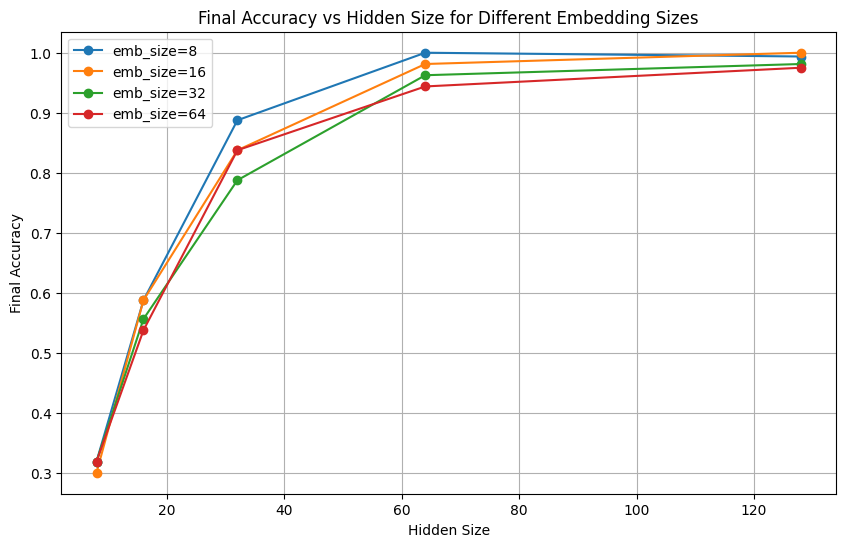

In [8]:
plt.figure(figsize=(10, 6))
for emb_size in df_results["emb_size"].unique():
    subset = df_results[df_results["emb_size"] == emb_size]
    plt.plot(subset["hidden_size"], subset["final_accuracy"], marker='o', label=f'emb_size={emb_size}')

plt.xlabel("Hidden Size")
plt.ylabel("Final Accuracy")
plt.title("Final Accuracy vs Hidden Size for Different Embedding Sizes")
plt.legend()
plt.grid()
plt.show()

Embedding_size de 8 et hidden size 64 semblent être le meilleur compromis entre performance et temps de calcul

# **Grid Search TPDN**

D'après les résultats précédent nous utiliserons les RNN avec une taille d'embedding de 8 et un hiddensize de 64 pour entraîner les TPDN (ratio performance/ temps de train). 

## TPDN gauche droite

In [5]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("./models/TPDN/GD", exist_ok=True)
os.makedirs("./resultats/TPDN/GD", exist_ok=True)

input_size = 10
output_size = 10

hidden_size = 64

num_layers = 1
batch_size = 16
seq_len = 10
epochs = 20000
learning_rate = 0.001

emb_sizes_tpdn = [4, 8, 16, 32, 64] 

results = []

encoder = torch.load("./models/GD/gru_enc_emb8_hid64.pth")

for emb_size_tpdn in emb_sizes_tpdn:
    print(f"\n--- emb_size_tpdn={emb_size_tpdn} ---\n")

    seq_len_tensor = torch.tensor([seq_len]).to(device)

    tpdnencoder = TensorProductEncoder(
        n_roles=seq_len,
        n_fillers=seq_len,
        filler_dim=emb_size_tpdn,
        role_dim=emb_size_tpdn,
        hidden_size=hidden_size
    ).to(device)

    tpdnencoder.train()

    criterion = nn.MSELoss()
    optimizer = optim.Adam(tpdnencoder.parameters(), lr=learning_rate)

    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        data, roles = generate_data(batch_size, seq_len, input_size)
        data = data.to(device)
        roles = roles.to(device)

        with torch.no_grad():
            _, encoder_hidden = encoder(data)
        
        encoder_hidden = encoder_hidden[-1, :, :]  
        tpdn_output = tpdnencoder(data, roles)[:, -1, :].to(device) 
        loss = criterion(tpdn_output, encoder_hidden)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        if (epoch + 1) % 2000 == 0:  
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}")

  
    torch.save(tpdnencoder, f"./models/TPDN/GD/tpdn_gru_emb{emb_size_tpdn}.pth")

    plt.figure()
    plt.plot(losses)
    plt.yscale('log')
    plt.title(f'Loss over Epochs (emb_size_tpdn={emb_size_tpdn})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(f"./resultats/TPDN/GD/loss_tpdn_emb{emb_size_tpdn}.png")
    plt.close()

    results.append({
        "emb_size_tpdn": emb_size_tpdn,
        "final_loss": losses[-1]
    })

df_results = pd.DataFrame(results)
df_results.to_csv("./resultats/TPDN/GD/grid_search_results_tpdn.csv", index=False)

print("\n--- tableau result svg ---")

/tmp/ipykernel_4952/500215222.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load("./models/GD/gru_enc_emb8_hid64.pth")



--- emb_size_tpdn=4 ---

Epoch [2000/20000], Loss: 0.082425
Epoch [4000/20000], Loss: 0.065352
Epoch [6000/20000], Loss: 0.055138
Epoch [8000/20000], Loss: 0.045054
Epoch [10000/20000], Loss: 0.040134
Epoch [12000/20000], Loss: 0.039739
Epoch [14000/20000], Loss: 0.040481
Epoch [16000/20000], Loss: 0.037879
Epoch [18000/20000], Loss: 0.038163
Epoch [20000/20000], Loss: 0.036474

--- emb_size_tpdn=8 ---

Epoch [2000/20000], Loss: 0.029871
Epoch [4000/20000], Loss: 0.021911
Epoch [6000/20000], Loss: 0.014503
Epoch [8000/20000], Loss: 0.013213
Epoch [10000/20000], Loss: 0.013176
Epoch [12000/20000], Loss: 0.011303
Epoch [14000/20000], Loss: 0.013161
Epoch [16000/20000], Loss: 0.011146
Epoch [18000/20000], Loss: 0.011223
Epoch [20000/20000], Loss: 0.012816

--- emb_size_tpdn=16 ---

Epoch [2000/20000], Loss: 0.017136
Epoch [4000/20000], Loss: 0.016250
Epoch [6000/20000], Loss: 0.013346
Epoch [8000/20000], Loss: 0.012959
Epoch [10000/20000], Loss: 0.010548
Epoch [12000/20000], Loss: 0.0123

In [6]:
df_results = pd.read_csv("./resultats/TPDN/GD/grid_search_results_tpdn.csv")
df_results

,emb_size_tpdn,final_loss
0,4,0.036474
1,8,0.012816
2,16,0.012843
3,32,0.011803
4,64,0.012066


## TPDN droite gauche 

In [3]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("./models/TPDN/DG", exist_ok=True)
os.makedirs("./resultats/TPDN/DG", exist_ok=True)

input_size = 10
emb_size = 8
hidden_size = 64

output_size = 10
num_layers = 1
batch_size = 16
seq_len = 10
epochs = 20000
learning_rate = 0.001

emb_sizes_tpdn = [4, 8, 16, 32, 64] 

results = []

encoder = torch.load("./models/DG/gru_enc_emb8_hid64.pth")

for emb_size_tpdn in emb_sizes_tpdn:
    print(f"\n--- emb_size_tpdn={emb_size_tpdn} ---\n")

    seq_len_tensor = torch.tensor([seq_len]).to(device)

    tpdnencoder = TensorProductEncoder(
        n_roles=seq_len,
        n_fillers=seq_len,
        filler_dim=emb_size_tpdn,
        role_dim=emb_size_tpdn,
        hidden_size=hidden_size
    ).to(device)

    tpdnencoder.train()

    criterion = nn.MSELoss()
    optimizer = optim.Adam(tpdnencoder.parameters(), lr=learning_rate)

    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        data, roles = generate_data(batch_size, seq_len, input_size)
        data = data.to(device)
        roles = roles.to(device)
        roles = torch.flip(roles, dims=[1])

        with torch.no_grad():
            _, encoder_hidden = encoder(data)
        
        encoder_hidden = encoder_hidden[-1, :, :]  
        tpdn_output = tpdnencoder(data, roles)[:, -1, :].to(device) 
        loss = criterion(tpdn_output, encoder_hidden)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        if (epoch + 1) % 2000 == 0:  
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}")

  
    torch.save(tpdnencoder, f"./models/TPDN/DG/tpdn_gru_emb{emb_size_tpdn}.pth")

    plt.figure()
    plt.plot(losses)
    plt.yscale('log')
    plt.title(f'Loss over Epochs (emb_size_tpdn={emb_size_tpdn})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(f"./resultats/TPDN/DG/loss_tpdn_emb{emb_size_tpdn}.png")
    plt.close()

    results.append({
        "emb_size_tpdn": emb_size_tpdn,
        "final_loss": losses[-1]
    })

df_results = pd.DataFrame(results)
df_results.to_csv("./resultats/TPDN/DG/grid_search_results_tpdn.csv", index=False)

print("\n--- tableau result svg ---")



/tmp/ipykernel_4952/2757892284.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load("./models/DG/gru_enc_emb8_hid64.pth")



--- emb_size_tpdn=4 ---

Epoch [2000/20000], Loss: 0.072392
Epoch [4000/20000], Loss: 0.059952
Epoch [6000/20000], Loss: 0.052753
Epoch [8000/20000], Loss: 0.047015
Epoch [10000/20000], Loss: 0.049540
Epoch [12000/20000], Loss: 0.046589
Epoch [14000/20000], Loss: 0.042920
Epoch [16000/20000], Loss: 0.047076
Epoch [18000/20000], Loss: 0.049603
Epoch [20000/20000], Loss: 0.049941

--- emb_size_tpdn=8 ---

Epoch [2000/20000], Loss: 0.035072
Epoch [4000/20000], Loss: 0.020500
Epoch [6000/20000], Loss: 0.014292
Epoch [8000/20000], Loss: 0.015833
Epoch [10000/20000], Loss: 0.012272
Epoch [12000/20000], Loss: 0.012245
Epoch [14000/20000], Loss: 0.012194
Epoch [16000/20000], Loss: 0.014955
Epoch [18000/20000], Loss: 0.015056
Epoch [20000/20000], Loss: 0.013699

--- emb_size_tpdn=16 ---

Epoch [2000/20000], Loss: 0.015108
Epoch [4000/20000], Loss: 0.013920
Epoch [6000/20000], Loss: 0.012318
Epoch [8000/20000], Loss: 0.010041
Epoch [10000/20000], Loss: 0.008106
Epoch [12000/20000], Loss: 0.0082

In [4]:
df_results = pd.read_csv("./resultats/TPDN/DG/grid_search_results_tpdn.csv")
df_results

,emb_size_tpdn,final_loss
0,4,0.049941
1,8,0.013699
2,16,0.008603
3,32,0.008770
4,64,0.009037
